In [279]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

def radius_to_capacitance(np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*np_radius

    return cap

def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, a0, beta):
    return a0*(1 - np.exp(-(t/tau)**beta))
def streched_moments(tau, beta, n=1):
    return gamma(n/np.array(beta))*(np.array(tau)**n)/np.array(beta)

### 2 Electrode Setup

In [280]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs/"
folder                  = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_two_step_input/steps_15000/"
U_0                     = 0.1
N_voltages              = 200000
t_vals                  = np.arange(N_voltages-1)*1e-10*1e9
steps_between_storage   = [0,100,200,400,600,800,1000,1200,1600,1800,2000,3000,4000,5000,7500,10000,20000,30000,40000,50000]
data                    = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=2_{steps}.csv") for steps in steps_between_storage}
pot                     = {steps : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Nz=1_Ne=2_{steps}.csv") for steps in steps_between_storage}

In [281]:
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
U_0         = 0.1
N_voltages  = 200000
t_true      = np.arange(N_voltages-1)*1e-10*1e9
cap         = 5e3
data_true   = pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=2_{cap}.csv")
y_true      = data_true['Current'].copy().values*1000

In [473]:
def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, beta, a0):
    return a0*(1 - np.exp(-(t/tau)**beta))
def double_exp_saturation(t, tau0, a0, tau1, a1):
    return a0*(1 - np.exp(-t/tau0)) + a1*(1 - np.exp(-t/tau1))
def triple_exp_saturation(t, tau0, a0, tau1, a1, tau2, a2):
    return a0*(1 - np.exp(-t/tau0)) + a1*(1 - np.exp(-t/tau1)) + a2*(1 - np.exp(-t/tau2))

p_e, c_e    = curve_fit(exp_saturation, t_true, y_true, bounds=(0, np.inf), p0=[1200,100])
p_k, c_k    = curve_fit(stretched_exp_saturation, t_true, y_true, bounds=(0, np.inf), p0=[1200,1,100])
p_d, c_d    = curve_fit(double_exp_saturation, t_true, y_true, bounds=(0, np.inf))
p_t, c_t    = curve_fit(triple_exp_saturation, t_true, y_true, bounds=(0, np.inf))

Text(0.5, 0, '$t$')

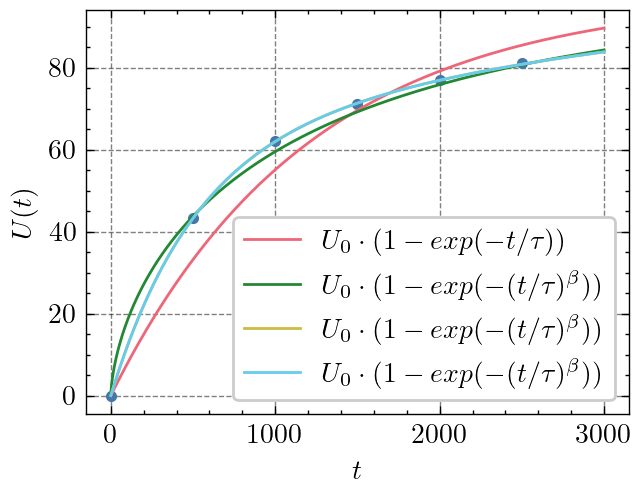

In [505]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
end = 30000
ax.plot(t_true[:end], y_true[:end], '.', markevery=5000)
ax.plot(t_true[:end], exp_saturation(t_true[:end], *p_e), label='$U_0\cdot(1-exp(-t/\\tau))$')
ax.plot(t_true[:end], stretched_exp_saturation(t_true[:end], *p_k), label='$U_0\cdot(1-exp(-(t/\\tau)^\\beta))$')
ax.plot(t_true[:end], double_exp_saturation(t_true[:end], *p_d), label='$U_0\cdot(1-exp(-(t/\\tau)^\\beta))$')
ax.plot(t_true[:end], triple_exp_saturation(t_true[:end], *p_t), label='$U_0\cdot(1-exp(-(t/\\tau)^\\beta))$')
ax.legend()
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")

In [524]:
a0      = p_k[2]
tau     = p_k[0]
beta    = p_k[1]

def stretched_exp_saturation_true(t, lam, t0):
    t_shift = np.clip(t - t0, 0, None)
    return a0*(1 - np.exp(-lam*(t_shift/tau)**beta))

In [512]:
tau_0   = p_d[0]
a0      = p_d[1]
tau_1   = p_d[2]
a1      = p_d[3]

def stretched_exp_saturation_true(t, lam, t0):
    t_shift = np.clip(t-t0,0,None)
    return a0*(1 - np.exp(-lam*(t_shift)/tau_0)) + a1*(1 - np.exp(-lam*(t_shift)/tau_1))

In [518]:
tau_0   = p_t[0]
a0      = p_t[1]
tau_1   = p_t[2]
a1      = p_t[3]
tau_2   = p_t[4]
a2      = p_t[5]

def stretched_exp_saturation_true(t, lam, t0):
    t_shift = np.clip(t-t0,0,None)
    return a0*(1 - np.exp(-lam*(t_shift)/tau_0)) + a1*(1 - np.exp(-lam*(t_shift)/tau_1)) + a2*(1 - np.exp(-lam*(t_shift)/tau_2))

In [525]:
steps_per_step  = 15000
step_idx        = [[0,steps_per_step,steps_per_step+steps,2*steps_per_step+steps] for steps in steps_between_storage]

In [526]:
start   = 0
t   = t_vals[start:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]+start:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(stretched_exp_saturation_true, t, y, maxfev=10000, bounds=(0, np.inf))

t1  = t_vals[start:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]+start:step_idx[0][1]]['Current'].values*1000
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000

p1,c1   = curve_fit(stretched_exp_saturation_true, t1, y1, maxfev=10000, bounds=(0, np.inf))
p2,c2   = curve_fit(stretched_exp_saturation_true, t2, y2, maxfev=10000, bounds=(0, np.inf))

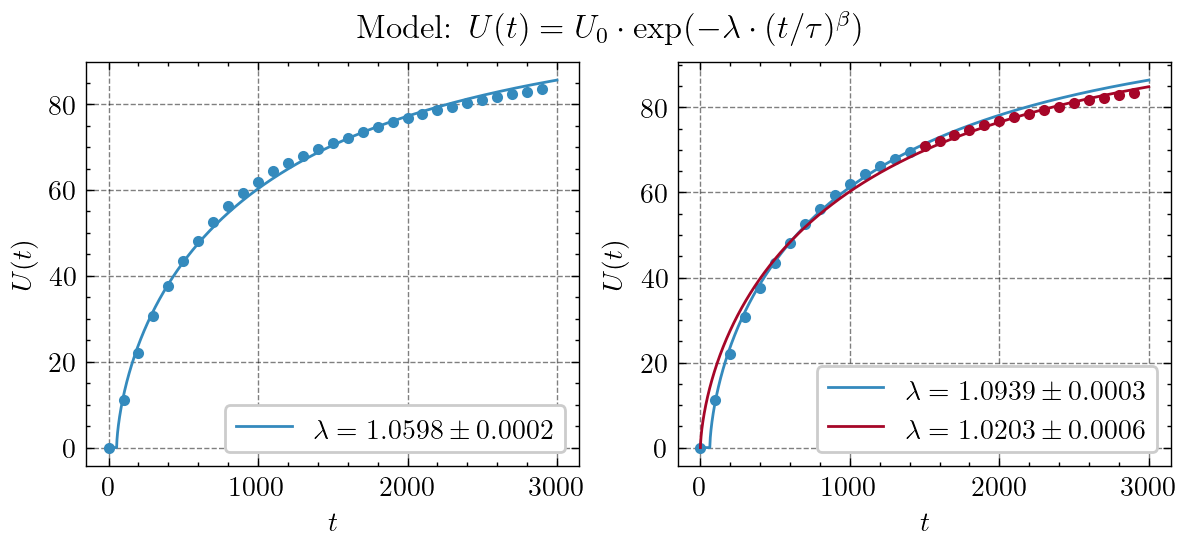

In [527]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, stretched_exp_saturation_true(t,*p), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p[0],4)} \pm {np.round(np.sqrt(c[0,0]),4)}$")
ax.legend()
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
# ax.set_xscale('log')
# ax.set_yscale('log')
ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, stretched_exp_saturation_true(t,*p1), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p1[0],4)} \pm {np.round(np.sqrt(c1[0,0]),4)}$")
ax.plot(t2, y2, '.', markevery=1000, color=nanonets_utils.red_color)
ax.plot(t, stretched_exp_saturation_true(t,*p2), color=nanonets_utils.red_color,
        label=f"$\\lambda = {np.round(p2[0],4)} \pm {np.round(np.sqrt(c2[0,0]),4)}$")
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
ax.legend()
# ax.set_xscale('log')
# ax.set_yscale('log')
fig.suptitle("Model: $U(t) = U_0 \cdot \\exp(-\\lambda \cdot (t/\\tau)^\\beta)$")
fig.savefig("fit.png")

In [532]:
params1 = []
params2 = []
tau1    = []
tau2    = []
t1_vals = []
t2_vals = []
y1_vals = []
y2_vals = []
start   = 0

for i, (key, df) in enumerate(data.items()):
    y   = df['Current'].values*1000

    # First range
    t1  =   t_vals.copy()[step_idx[i][0]+start:step_idx[i][1]]
    y1  =   y.copy()[step_idx[i][0]+start:step_idx[i][1]]
    p1,_=   curve_fit(stretched_exp_saturation_true, t1, y1, bounds=(0,np.inf))
    tau1.append(p1[0])
    t1_vals.append(t1)
    y1_vals.append(y1)
    params1.append(p1)

    # Second range
    t2  =   t_vals.copy()[step_idx[i][2]+start:step_idx[i][3]]
    y2  =   y.copy()[step_idx[i][2]+start:step_idx[i][3]]
    p2,_=   curve_fit(stretched_exp_saturation_true, t2, y2, bounds=(0,np.inf))
    # p2,_=   curve_fit(stretched_exp_saturation, t1, y2, p0=p1, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
    tau2.append(p2[0])
    t2_vals.append(t2)
    y2_vals.append(y2)
    params2.append(p2)

tau_df                      = pd.DataFrame([tau1,tau2],index=["$\\tau_1$","$\\tau_2$"], columns=np.array(steps_between_storage)/10).T
tau_df["$\Delta \\tau$"]    = np.abs(tau_df["$\\tau_2$"] - tau_df["$\\tau_1$"])
tau_df

,$\tau_1$,$\tau_2$,$\Delta \tau$
0.0,1.093899,1.020321,0.073578
10.0,1.095753,1.000539,0.095215
20.0,1.097248,0.983090,0.114158
40.0,1.094046,0.947443,0.146603
60.0,1.098665,0.938823,0.159841
80.0,1.097567,0.919283,0.178284
100.0,1.095071,0.937033,0.158038
120.0,1.097465,0.952796,0.144669
160.0,1.095083,0.965333,0.129751
180.0,1.095423,0.968220,0.127203


Text(0, 0.5, '$\\Delta \\lambda$')

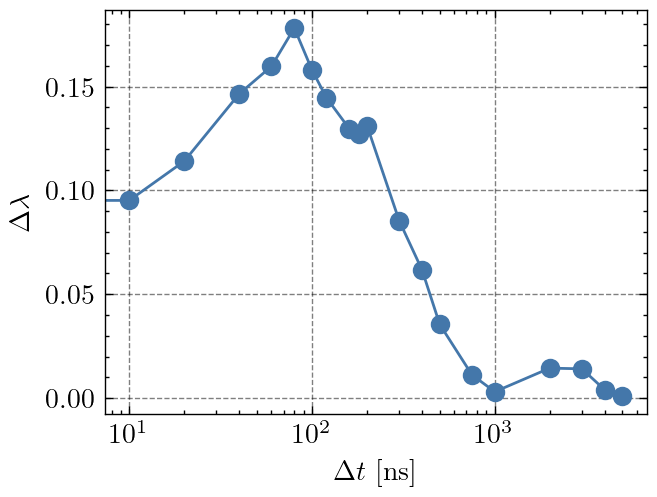

In [534]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,tau_df.iloc[:,2], 'o-')
ax.set_xscale('log')
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$\Delta \\lambda$")
# fig.savefig(f"../plots/dc_input/2_electrodes/delta_tau_vs_delta_t.svg", transparent=True)

Text(0, 0.5, '$t_0$ [ns]')

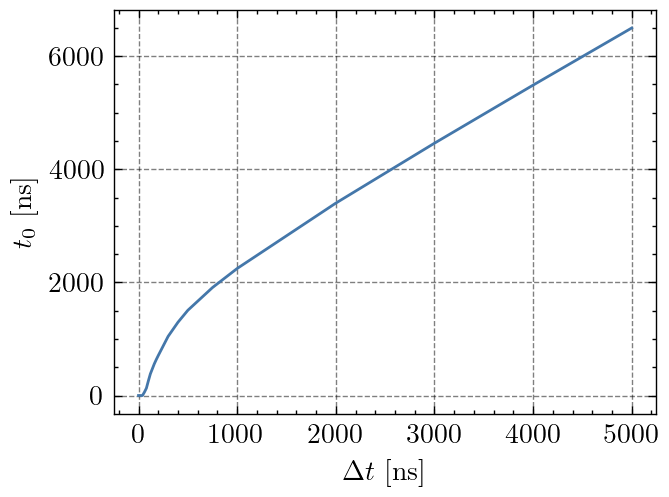

In [537]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,np.array(params2)[:,1])
# ax.set_xscale('log')
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$t_0$ [ns]")

Text(0.5, 0, '$t$ [ns]')

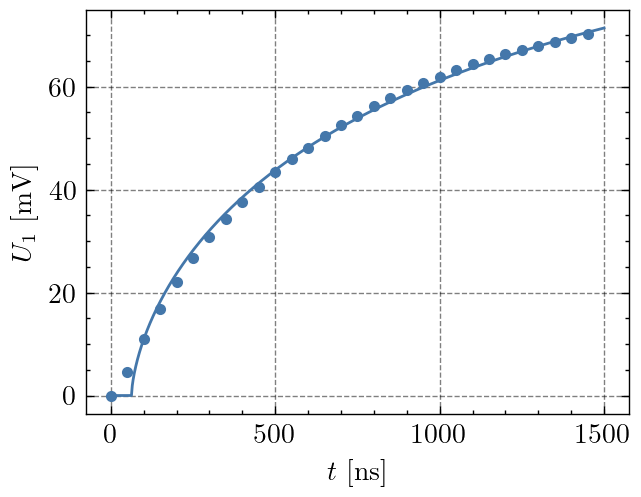

In [538]:
idx = 0
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p   = ax.plot(t1_vals[idx], y1_vals[idx], '.', markevery=500)
ax.plot(t1_vals[idx], stretched_exp_saturation_true(t1_vals[idx],*params1[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
# fig.savefig(f"../plots/dc_input/2_electrodes/fit_1.svg", transparent=True)

(20.0, 80.0)

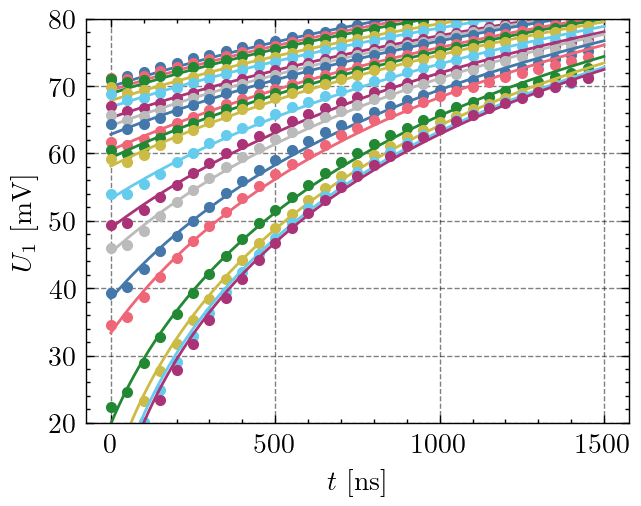

In [539]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for idx in range(len(t2_vals)):
    p = ax.plot(t1_vals[idx], y2_vals[idx], '.', markevery=500)
    ax.plot(t1_vals[idx], stretched_exp_saturation_true(t2_vals[idx],*params2[idx]), color=p[0].get_color())
    # ax.plot(t2_vals[idx], stretched_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.set_ylim(20,80)
# fig.savefig(f"../plots/dc_input/2_electrodes/fit_2.svg", transparent=True)

---

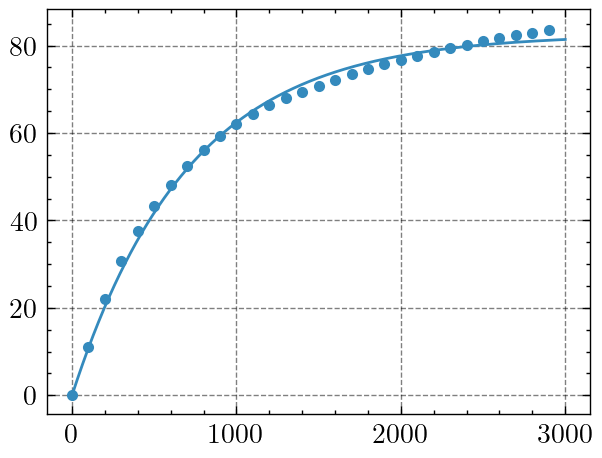

In [540]:
def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))

t   = t_vals[:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(exp_saturation, t, y, maxfev=10000)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p), color=nanonets_utils.blue_color)

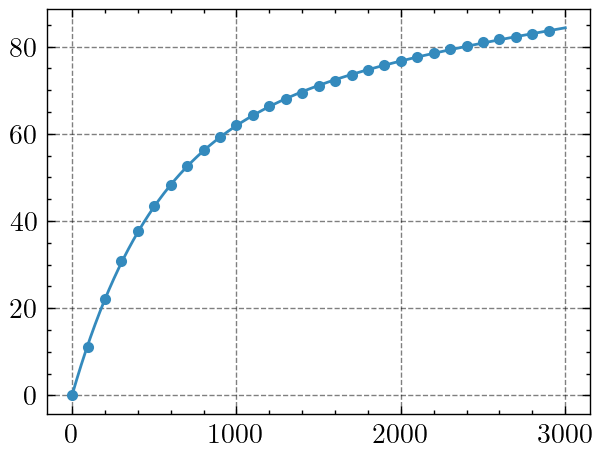

In [196]:
def exp_saturation(t, tau, a0, tau2, a1):
    return a0*(1 - np.exp(-t/tau)) + a1*(1 - np.exp(-t/tau2))

t   = t_vals[:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(exp_saturation, t, y, maxfev=10000)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p), color=nanonets_utils.blue_color)

In [145]:
def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))

t   = t_vals[:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(exp_saturation, t, y, maxfev=10000)

t1  = t_vals[:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]:step_idx[0][1]]['Current'].values*1000
# y1  = y1 - np.min(y1)
# t2  = t_vals[:step_idx[0][1]]
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000
# y2  = y2 - np.min(y2)

p1,c1   = curve_fit(exp_saturation, t1, y1, maxfev=10000)
p2,c2   = curve_fit(exp_saturation, t2, y2, maxfev=10000, p0=p1)

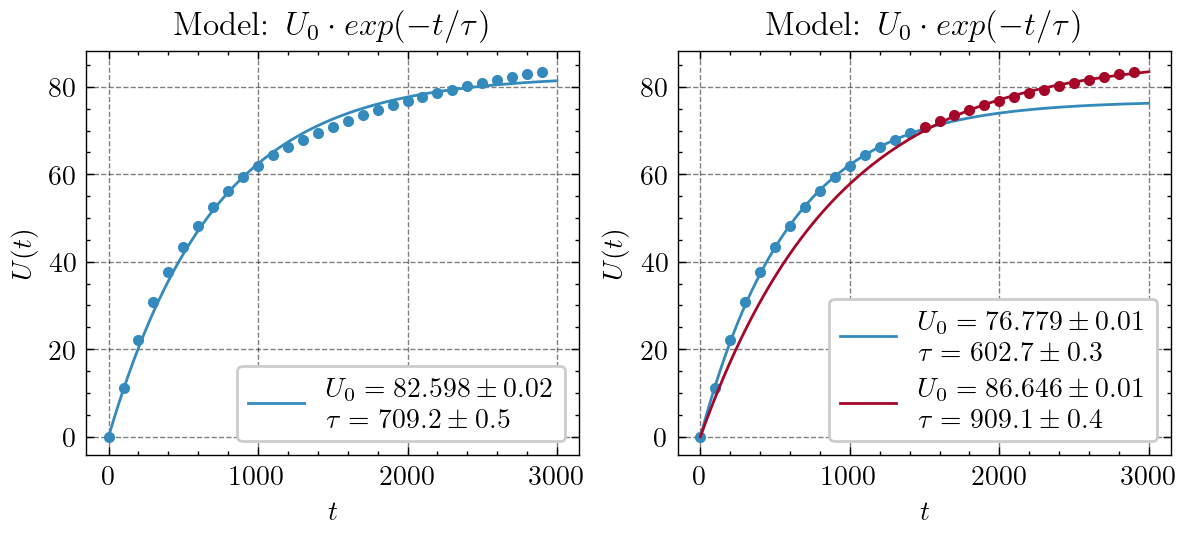

In [146]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p), color=nanonets_utils.blue_color,
        label=f"$U_0 = {np.round(p[1],3)} \pm {np.round(np.sqrt(c[1,1]),2)}$\n$\\tau = {np.round(p[0],1)} \pm {np.round(np.sqrt(c[0,0]),1)}$")
ax.legend()
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau)$")
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
# ax.set_xscale('log')
# ax.set_yscale('log')
ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p1), color=nanonets_utils.blue_color,
        label=f"$U_0 = {np.round(p1[1],3)} \pm {np.round(np.sqrt(c1[1,1]),2)}$\n$\\tau = {np.round(p1[0],1)} \pm {np.round(np.sqrt(c1[0,0]),1)}$")
ax.plot(t2, y2, '.', markevery=1000, color=nanonets_utils.red_color)
ax.plot(t, exp_saturation(t,*p2), color=nanonets_utils.red_color,
        label=f"$U_0 = {np.round(p2[1],3)} \pm {np.round(np.sqrt(c2[1,1]),2)}$\n$\\tau = {np.round(p2[0],1)} \pm {np.round(np.sqrt(c2[0,0]),1)}$")
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau)$")
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
ax.legend()
# ax.set_xscale('log')
# ax.set_yscale('log')
fig.savefig("fit.png")

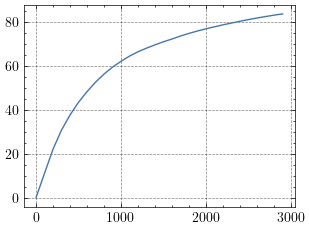

In [190]:
plt.plot(t[::1000],y[::1000])

In [192]:
y[::1000]

array([1.47588897e-03, 1.10767900e+01, 2.20501136e+01, 3.07308985e+01,
       3.75858510e+01, 4.33580513e+01, 4.81949507e+01, 5.24932312e+01,
       5.61843438e+01, 5.93267254e+01, 6.19638009e+01, 6.43437568e+01,
       6.63171001e+01, 6.79490733e+01, 6.94510613e+01, 7.08572734e+01,
       7.21097111e+01, 7.34675622e+01, 7.46670059e+01, 7.57584673e+01,
       7.67551740e+01, 7.76596387e+01, 7.85498332e+01, 7.93574343e+01,
       8.01809022e+01, 8.09411832e+01, 8.16438662e+01, 8.23102543e+01,
       8.29428548e+01, 8.35069561e+01])

In [197]:
a0  = 80
def exp_saturation(t, tau):
    return a0*(1 - np.exp(-t/tau))

t   = t_vals[:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(exp_saturation, t, y, maxfev=10000)

t1  = t_vals[:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]:step_idx[0][1]]['Current'].values*1000
# y1  = y1 - np.min(y1)
# t2  = t_vals[:step_idx[0][1]]
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000
# y2  = y2 - np.min(y2)

p1,c1   = curve_fit(exp_saturation, t1, y1, maxfev=10000)
p2,c2   = curve_fit(exp_saturation, t2, y2, maxfev=10000, p0=p1)

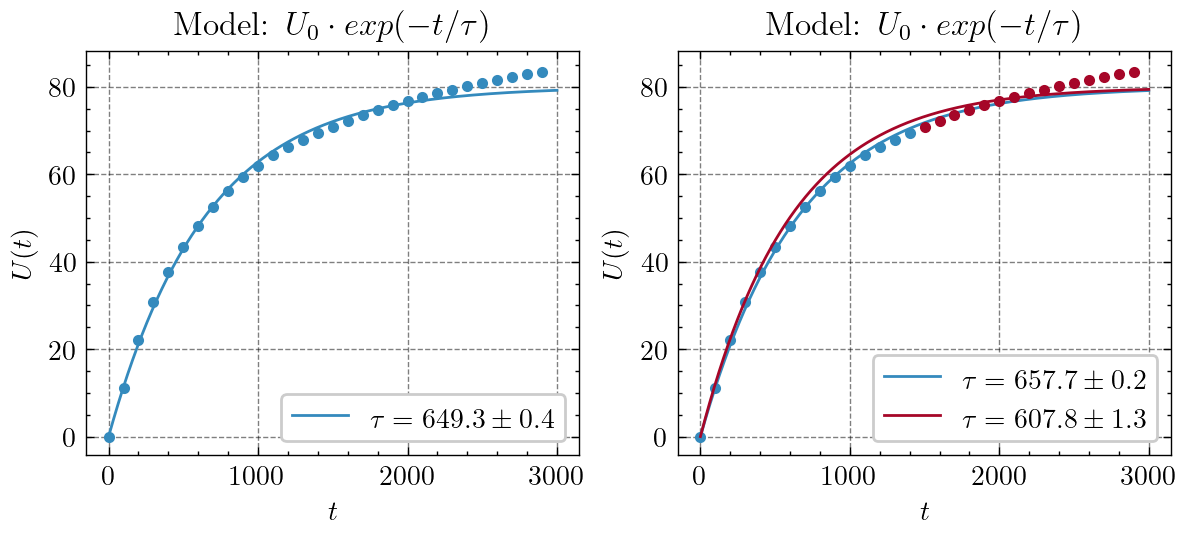

In [198]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p), color=nanonets_utils.blue_color,
        label=f"$\\tau = {np.round(p[0],1)} \pm {np.round(np.sqrt(c[0,0]),1)}$")
ax.legend()
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau)$")
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")

ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p1), color=nanonets_utils.blue_color,
        label=f"$\\tau = {np.round(p1[0],1)} \pm {np.round(np.sqrt(c1[0,0]),1)}$")
ax.plot(t2, y2, '.', markevery=1000, color=nanonets_utils.red_color)
ax.plot(t, exp_saturation(t,*p2), color=nanonets_utils.red_color,
        label=f"$\\tau = {np.round(p2[0],1)} \pm {np.round(np.sqrt(c2[0,0]),1)}$")
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau)$")
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
ax.legend()

In [193]:
def exp_saturation(t, tau, a0, tau2, a1):
    return a0*(1 - np.exp(-t/tau)) + a1*(1 - np.exp(-t/tau2))

t   = t_vals[:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(exp_saturation, t, y, maxfev=10000, bounds=(0,np.inf))

t1  = t_vals[:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]:step_idx[0][1]]['Current'].values*1000
# y1  = y1 - np.min(y1)
# t2  = t_vals[:step_idx[0][1]]
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000
# y2  = y2 - np.min(y2)

p1,c1   = curve_fit(exp_saturation, t1, y1, maxfev=10000, p0=p, bounds=((0,0,0,0),(np.inf,200,np.inf,200)))
p2,c2   = curve_fit(exp_saturation, t2, y2, maxfev=10000, p0=p1, bounds=((0,0,0,0),(np.inf,200,np.inf,200)))

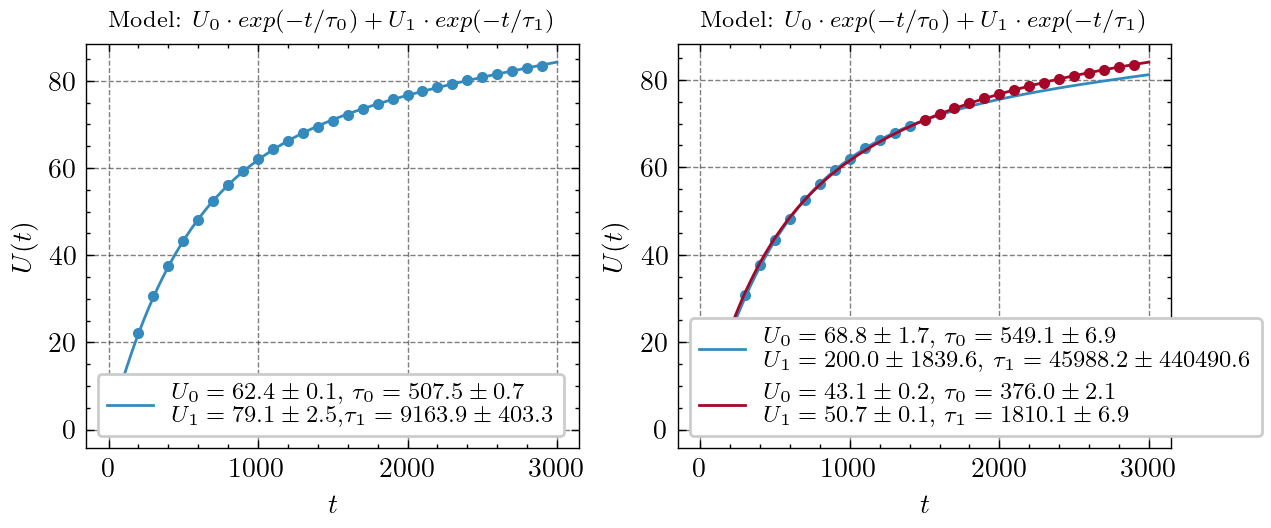

In [194]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p), color=nanonets_utils.blue_color,
        label=f"$U_0 = {np.round(p[1],1)} \pm {np.round(np.sqrt(c[1,1]),1)}$, $\\tau_0 = {np.round(p[0],1)} \pm {np.round(np.sqrt(c[0,0]),1)}$\n$U_1 = {np.round(p[3],1)} \pm {np.round(np.sqrt(c[3,3]),1)}$,$\\tau_1 = {np.round(p[2],1)} \pm {np.round(np.sqrt(c[2,2]),1)}$")
ax.legend(fontsize='small')
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau_0) + U_1 \cdot exp(-t/\\tau_1)$", fontsize='small')
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
# ax.set_xscale('log')
# ax.set_yscale('log')
ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=1000, color=nanonets_utils.blue_color)
ax.plot(t, exp_saturation(t,*p1), color=nanonets_utils.blue_color,
        label=f"$U_0 = {np.round(p1[1],1)} \pm {np.round(np.sqrt(c1[1,1]),1)}$, $\\tau_0 = {np.round(p1[0],1)} \pm {np.round(np.sqrt(c1[0,0]),1)}$\n$U_1 = {np.round(p1[3],1)} \pm {np.round(np.sqrt(c1[3,3]),1)}$, $\\tau_1 = {np.round(p1[2],1)} \pm {np.round(np.sqrt(c1[2,2]),1)}$")
ax.plot(t2, y2, '.', markevery=1000, color=nanonets_utils.red_color)
ax.plot(t, exp_saturation(t,*p2), color=nanonets_utils.red_color,
        label=f"$U_0 = {np.round(p2[1],1)} \pm {np.round(np.sqrt(c2[1,1]),1)}$, $\\tau_0 = {np.round(p2[0],1)} \pm {np.round(np.sqrt(c2[0,0]),1)}$\n$U_1 = {np.round(p2[3],1)} \pm {np.round(np.sqrt(c2[3,3]),1)}$, $\\tau_1 = {np.round(p2[2],1)} \pm {np.round(np.sqrt(c2[2,2]),1)}$")
ax.set_title("Model: $U_0 \cdot exp(-t/\\tau_0) + U_1 \cdot exp(-t/\\tau_1)$", fontsize='small')
ax.set_ylabel("$U(t)$")
ax.set_xlabel("$t$")
ax.legend(fontsize='small')
# ax.set_xscale('log')
# ax.set_yscale('log')
fig.savefig("fit2.png")

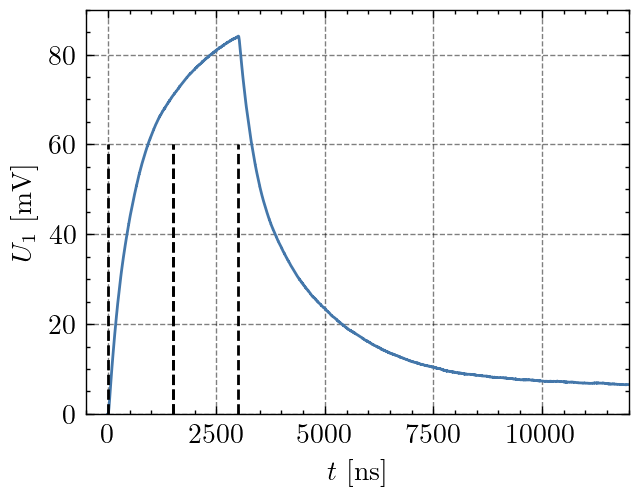

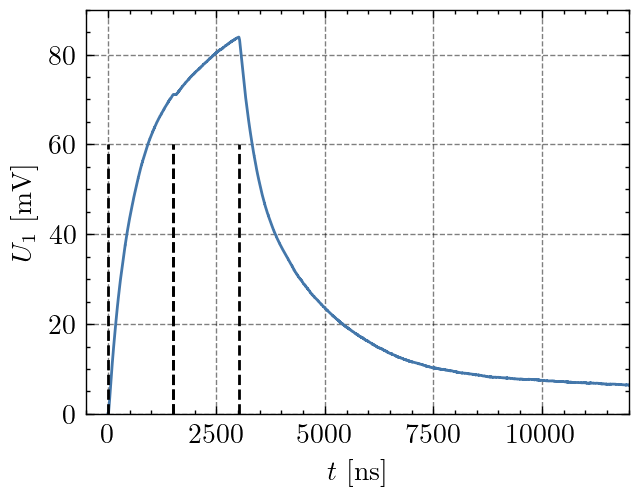

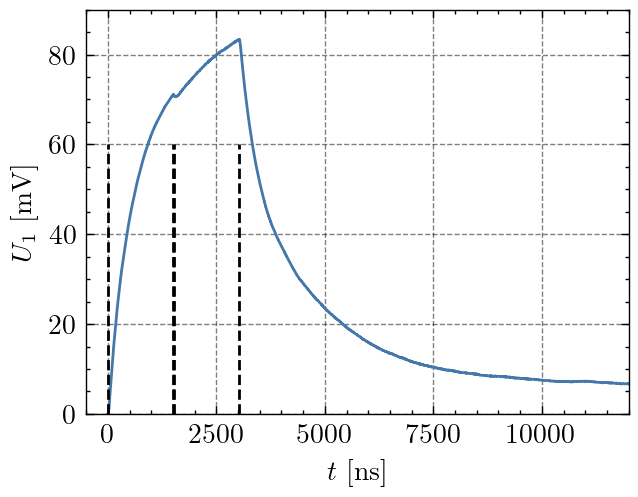

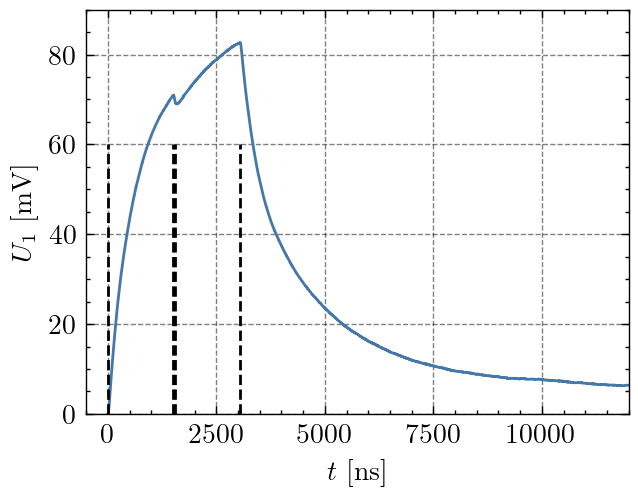

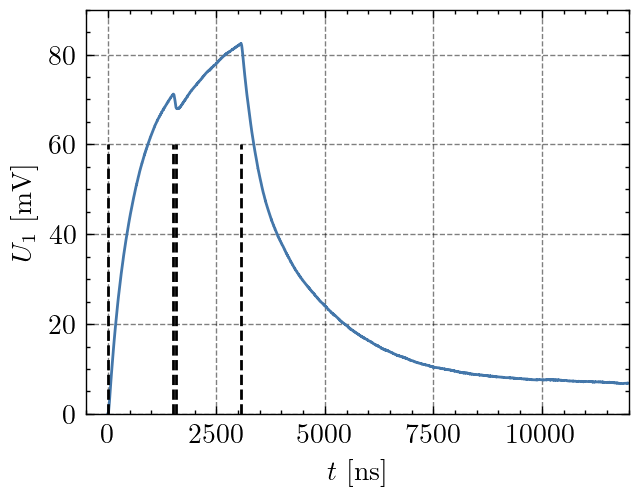

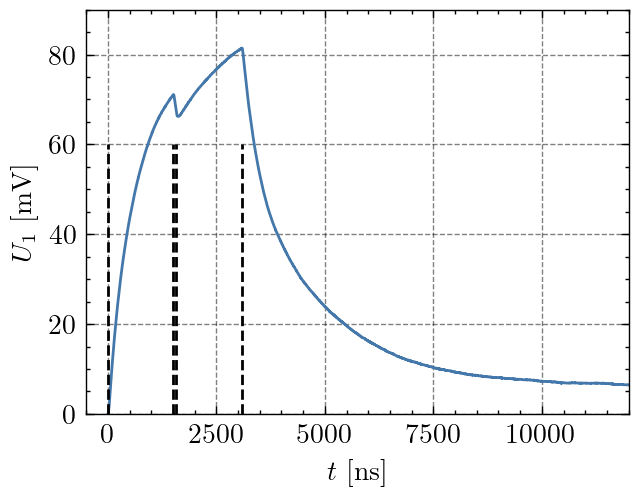

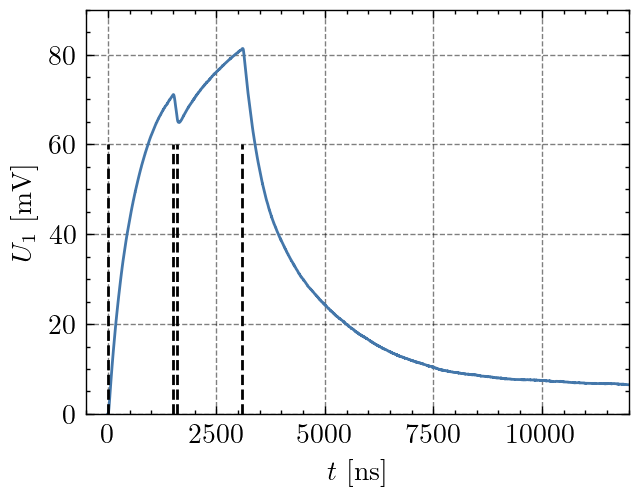

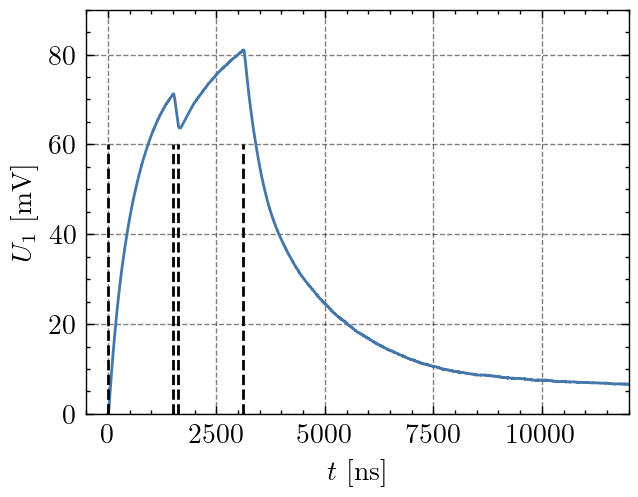

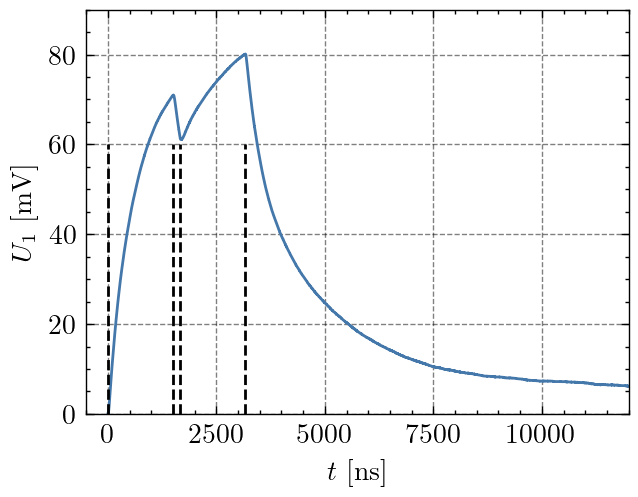

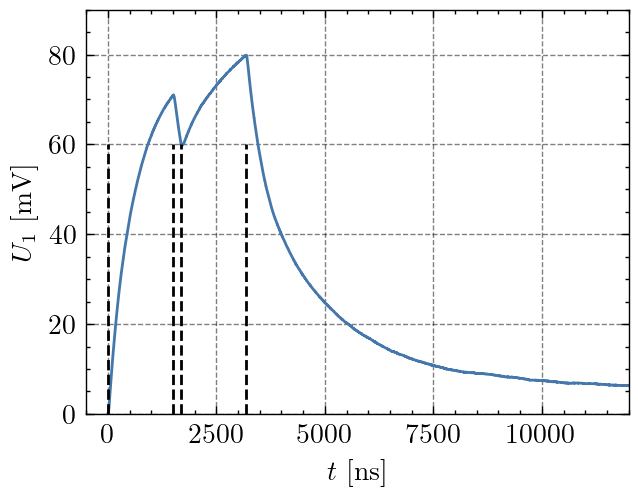

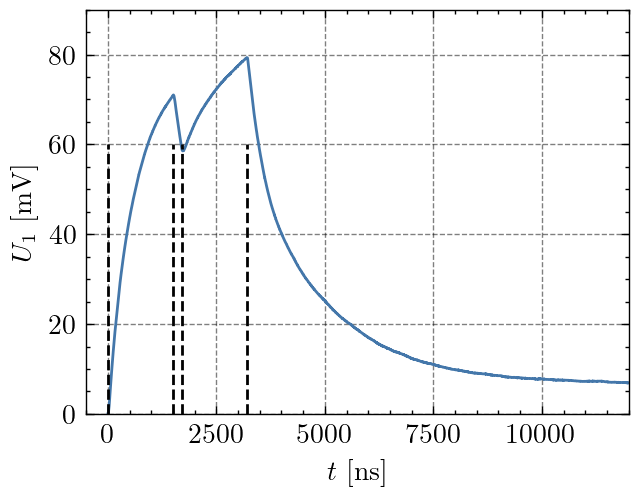

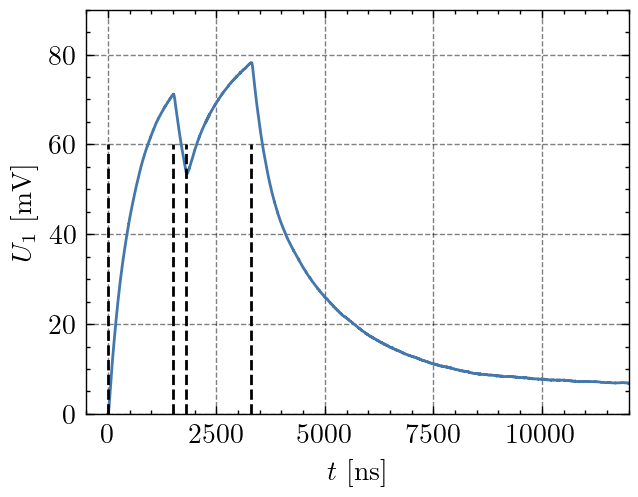

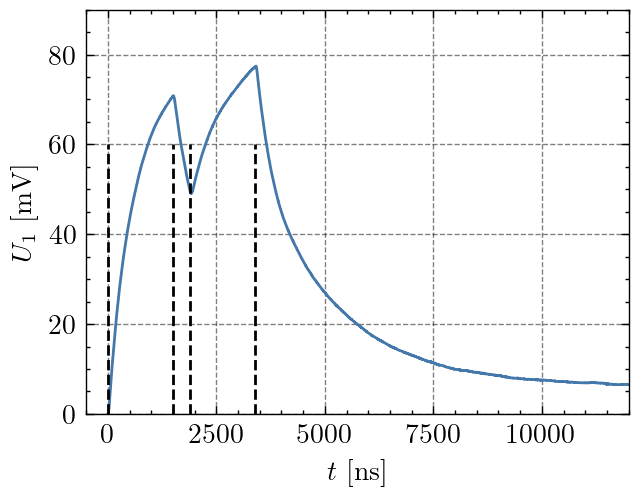

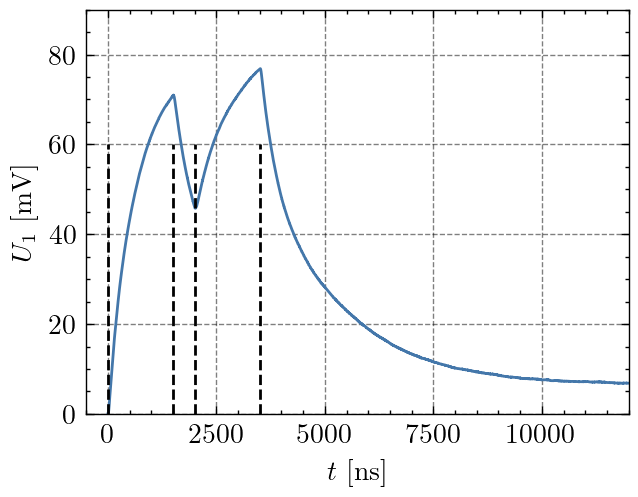

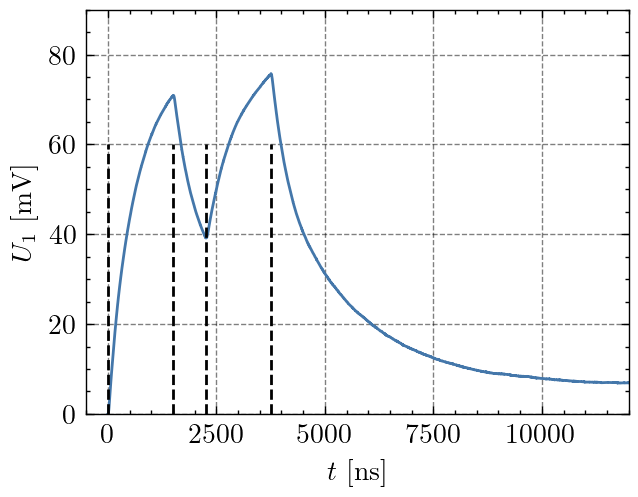

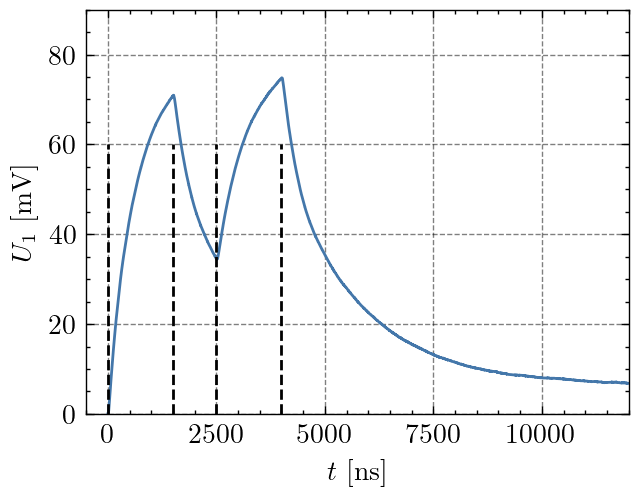

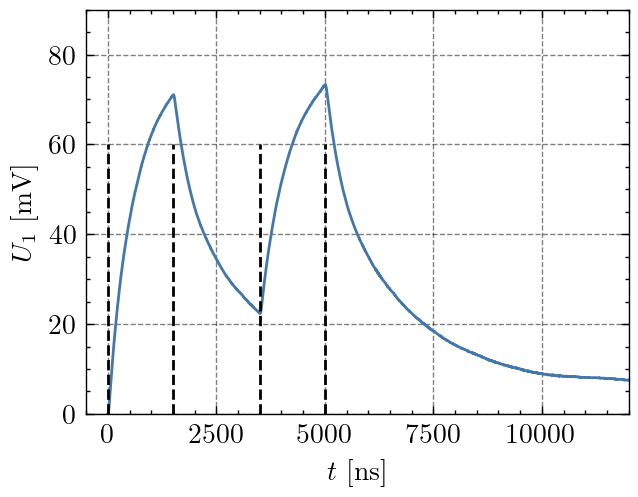

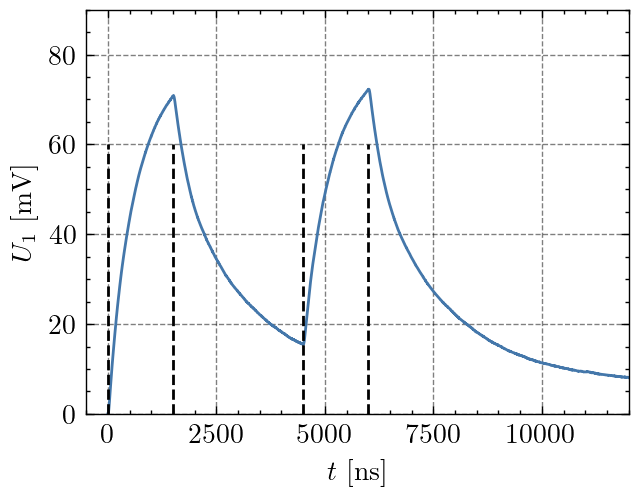

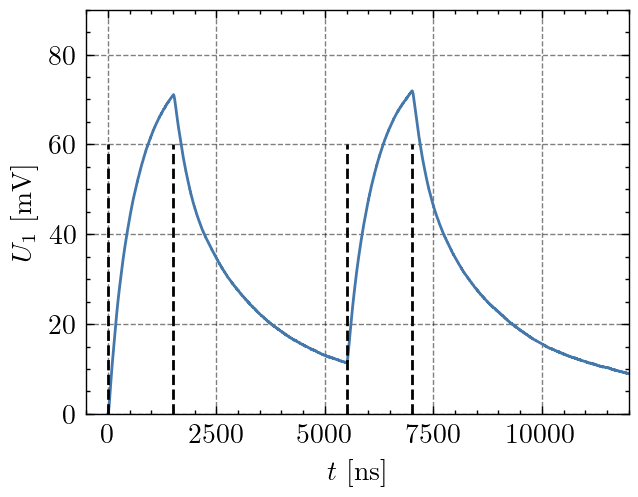

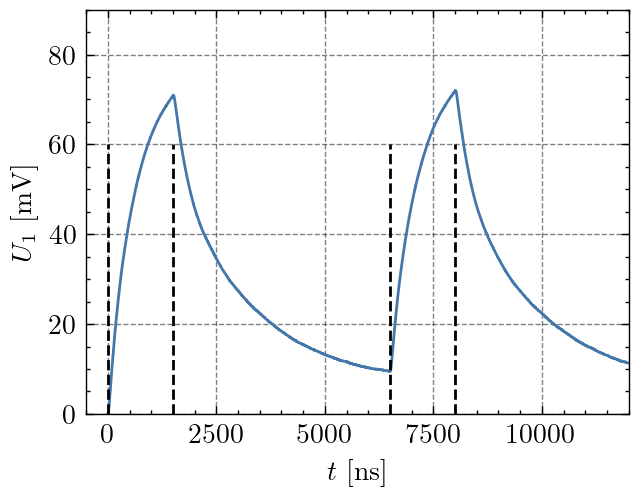

In [269]:
for steps in steps_between_storage:

    y_min   = 0
    y_max   = 100
    idx     = np.where(steps==np.array(steps_between_storage))[0][0]
    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    y       = data[steps]['Current'].values*1000
    y_e     = data[steps]['Error'].values*1000

    ax.plot(t_vals, y)
    ax.vlines(t_vals[step_idx[idx]], ymin=y_min, ymax=y_max-40, color='black', ls='--')
    ax.set_ylim(y_min, y_max-10)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U_1$ [mV]")
    ax.set_xlim(-500,12000)
    
    fig.savefig(f"../plots/dc_input/2_electrodes/two_steps/response_{steps}.svg", transparent=True)

In [18]:
def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, a0, beta):
    return a0*(1 - np.exp(-(t/tau)**beta))

params1 = []
params2 = []
tau1    = []
tau2    = []
t1_vals = []
t2_vals = []
y1_vals = []
y2_vals = []
skip    = 2000

for i, (key, df) in enumerate(data.items()):
    y   = df['Current'].values*1000

    # First range
    t1  =   t_vals.copy()[step_idx[i][0]:step_idx[i][1]-skip]
    y1  =   y.copy()[step_idx[i][0]+skip:step_idx[i][1]]
    y1  -=  y1.min()
    p1,_=   curve_fit(exp_saturation, t1, y1, p0=[600,75], bounds=((0,0),(np.inf,np.inf)))
    # p1,_=   curve_fit(stretched_exp_saturation, t1, y1, p0=[600,75,1], bounds=((0,0,0),(np.inf,np.inf,np.inf)))
    tau1.append(p1[0])
    # tau1.append(streched_moments(p1[0],p1[1]))
    t1_vals.append(t1)
    y1_vals.append(y1)
    params1.append(p1)

    # First range
    y2  =   y.copy()[step_idx[i][2]+skip:step_idx[i][3]]
    y2  -=  y2.min()
    p2,_=   curve_fit(exp_saturation, t1, y2, p0=p1, bounds=((0,0),(np.inf,np.inf)))
    # p2,_=   curve_fit(stretched_exp_saturation, t1, y2, p0=p1, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
    tau2.append(p2[0])
    # tau2.append(streched_moments(p2[0],p2[1]))
    t2_vals.append(t1)
    y2_vals.append(y2)
    params2.append(p2)

tau_df                      = pd.DataFrame([tau1,tau2],index=["$\\tau_1$","$\\tau_2$"], columns=np.array(steps_between_storage)/10).T
tau_df["$\Delta \\tau$"]    = np.abs(tau_df["$\\tau_2$"] - tau_df["$\\tau_1$"])
tau_df

,$\tau_1$,$\tau_2$,$\Delta \tau$
0.0,621.035031,1580.678101,959.643070
10.0,615.897679,2149.219989,1533.322311
20.0,621.396357,1659.630090,1038.233733
40.0,617.452721,1540.496053,923.043333
60.0,621.572353,1653.217120,1031.644767
80.0,621.462288,1648.639778,1027.177489
100.0,625.899507,1608.730226,982.830719
120.0,626.136114,1379.235649,753.099535
160.0,621.347564,1343.016311,721.668746
180.0,615.716439,1218.808623,603.092184


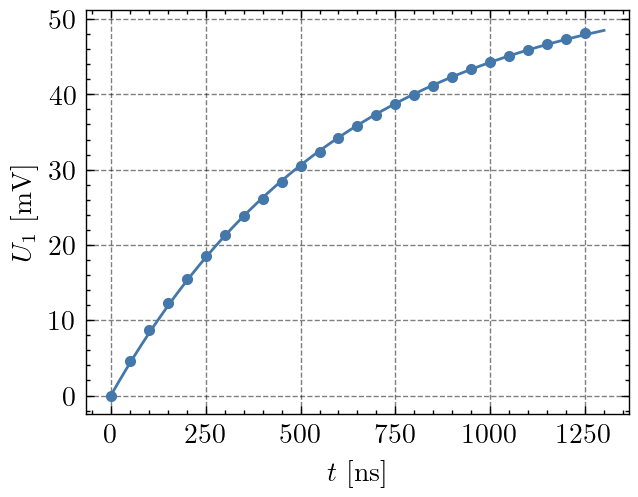

In [20]:
idx = 0
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p   = ax.plot(t1_vals[idx], y1_vals[idx], '.', markevery=500)
ax.plot(t1_vals[idx], exp_saturation(t1_vals[idx],*params1[idx]), color=p[0].get_color())
# ax.plot(t1_vals[idx], stretched_exp_saturation(t1_vals[idx],*params1[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
fig.savefig(f"../plots/dc_input/2_electrodes/fit_1.svg", transparent=True)

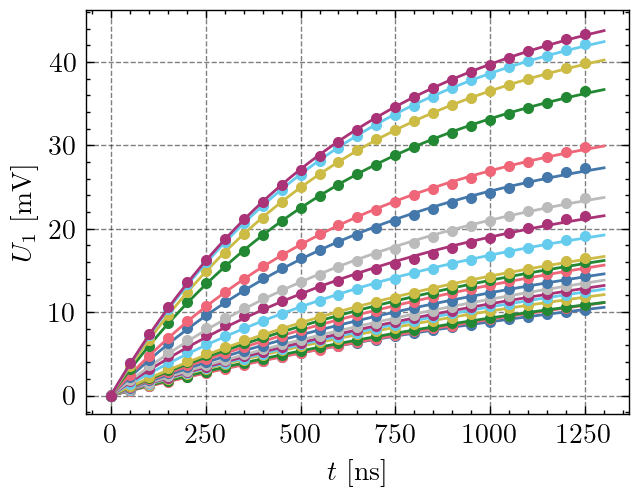

In [21]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for idx in range(len(t2_vals)):
    p = ax.plot(t2_vals[idx], y2_vals[idx], '.', markevery=500)
    ax.plot(t2_vals[idx], exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())
    # ax.plot(t2_vals[idx], stretched_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
fig.savefig(f"../plots/dc_input/2_electrodes/fit_2.svg", transparent=True)

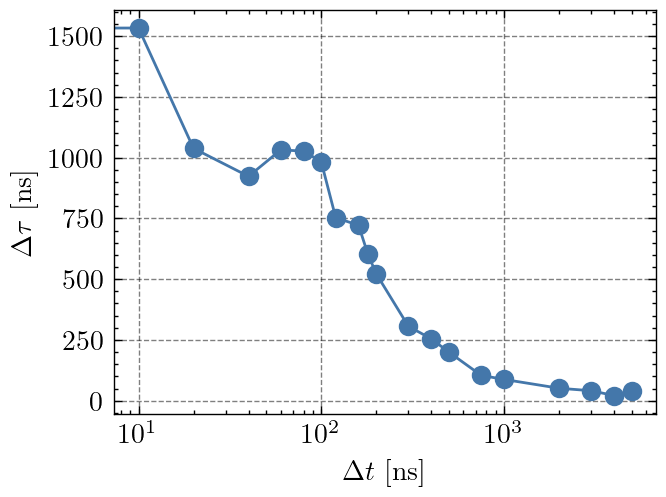

In [22]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,tau_df.iloc[:,2], 'o-')
ax.set_xscale('log')
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$\Delta \\tau$ [ns]")
fig.savefig(f"../plots/dc_input/2_electrodes/delta_tau_vs_delta_t.svg", transparent=True)

---

In [41]:
N_voltages      = 200000
steps_between_s = [0,400,800,1600,2000,4000,5000,10000,20000,40000]
steps_per_step  = 40000
time_step       = 1e-9
cap             = 5e3
U_0             = 0.1
t_vals          = np.arange(N_voltages-1)*time_step*1e6
# folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/two_step_input/"
folder          = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_two_step_input/"
data_two        = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{steps}.csv") for steps in steps_between_s}

[ 0.59337746 17.07230653]
[ 0.50047496 17.06951707]


(0.0, 10.0)

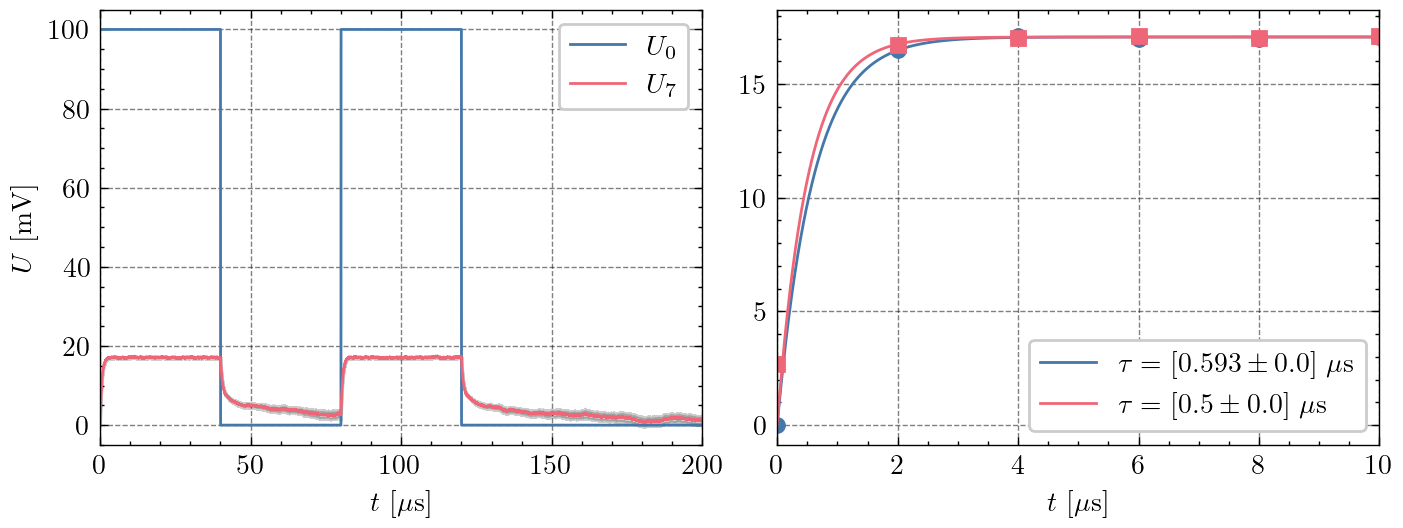

In [44]:
steps_between   = 40000
df              = data_two[steps_between].copy()
fuc             = exp_saturation

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000
y1  = y[:steps_per_step].copy()
y2  = y[steps_per_step+steps_between:2*steps_per_step+steps_between].copy()
# y1  -= y1[0]
# y2  -= y2[0]

ax.plot(t_vals, x, label='$U_0$')
ax.plot(t_vals, y, label='$U_7$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.set_ylabel('$U$ [mV]')
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
p,c = curve_fit(fuc, t_vals[:len(y1)], y1, p0=[2,100])
print(p)
p1  = ax.plot(t_vals[:len(y1)],y1, 'o', markevery=2000, ms=5)
ax.plot(t_vals[:len(y1)],fuc(t_vals[:len(y1)],*p), color=p1[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')

p,c = curve_fit(fuc, t_vals[:len(y2)],y2, p0=[2,50])#, bounds=[(0,0,0),(200,np.inf,1)])
print(p)
p2  = ax.plot(t_vals[:len(y2)],y2, 's', markevery=2000, ms=5)
ax.plot(t_vals[:len(y2)],fuc(t_vals[:len(y2)],*p), color=p2[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(loc='lower right')
# ax.set_xscale('log')
ax.set_xlim(0,10)

# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.svg", transparent=True)
# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.pdf", transparent=False)

## Increasing Steps

In [130]:
steps_per_step  = 40000
cap             = 5e3
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/increasing_steps/"
df              = pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") 
N_voltages      = len(df)
time_step       = 1e-10
t_vals          = np.arange(N_voltages)*1e-10*1e6

[22.65823247 58.07212674]
[ 3.27628609 17.8294665 ]
[ 7.41421575 43.06513887]
[ 2.98640029 23.38515884]
[ 6.25804016 45.95597669]
[4.97020421 1.42034047]
[ 26.6192968  -37.45821997]
[  4.15274332 -29.64337648]
[  2.49407201 -17.62077896]
[  4.37642488 -37.39508781]


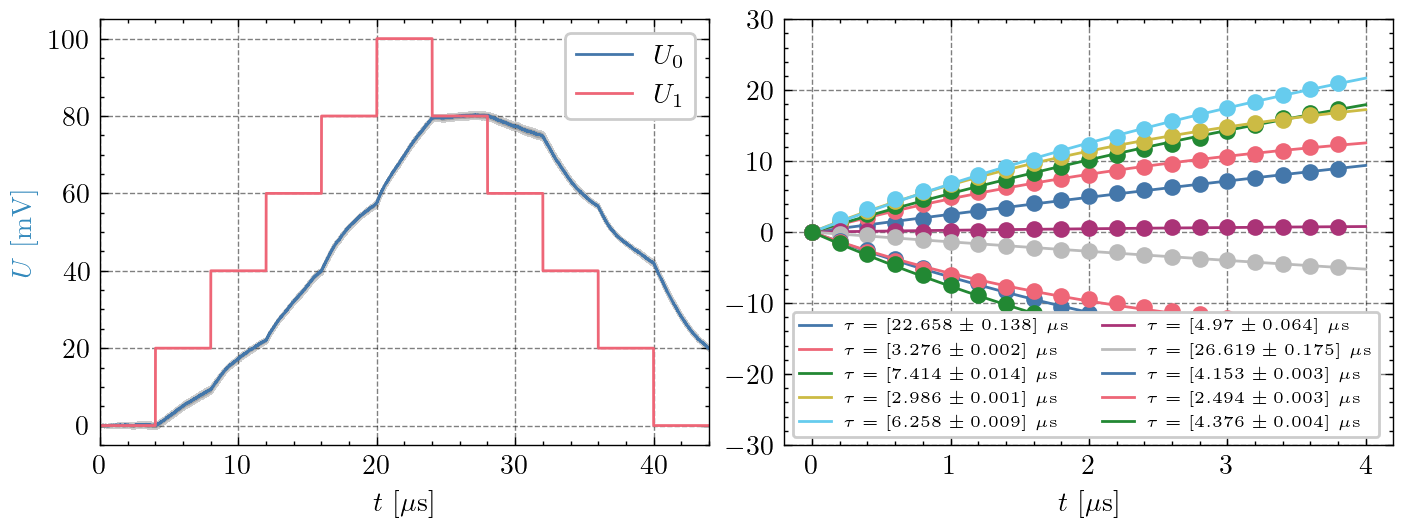

In [131]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]', color=nanonets_utils.blue_color)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
for i in range(1,11):
    y1  =   y[i*steps_per_step:(i+1)*steps_per_step].copy()
    y1  -=  y1[0]
    p,c = curve_fit(exp_saturation, t_vals[:len(y1)], y1)
    print(p)
    p1  = ax.plot(t_vals[:len(y1)], y1, 'o', markevery=2000, ms=5)
    ax.plot(t_vals[:len(y1)], exp_saturation(t_vals[:len(y1)], *p), color=p1[0].get_color(),
            label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(fontsize='xx-small', ncol=2)
ax.set_ylim(-30,30)

fig.savefig(f"../plots/increasing_steps.svg", transparent=True)
fig.savefig(f"../plots/increasing_steps.pdf", transparent=False)

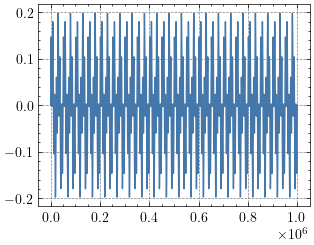

In [106]:
N_voltages  = 1000000
time_step   = 1e-9
U_0         = 0.1
time_steps  = np.arange(N_voltages)*time_step
f0          = 40e3
f1          = 140e3
U_i         = U_0*np.sin(2*np.pi*f0*time_steps) + U_0*np.sin(2*np.pi*f1*time_steps)
plt.plot(U_i)

In [68]:
y1              = y[:steps_per_step]
y2              = y[steps_per_step+steps_between:2*steps_per_step+steps_between]

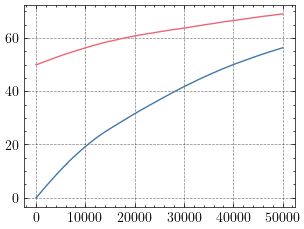

In [69]:
plt.plot(y1)
plt.plot(y2)

In [27]:
t_at_68 = []
U_th    = U_0*0.1 #U_0*0.63

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > U_th)[0][0]])

t_at_68

IndexError: index 0 is out of bounds for axis 0 with size 0

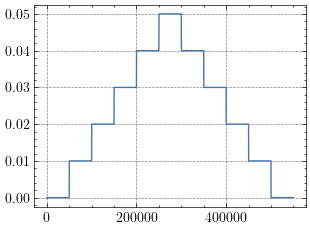

In [66]:
steps_per_step  = 50000
U_step          = 0.01
U_i1            = U_step*np.repeat(np.arange(6),steps_per_step)
U_i2            = U_step*np.repeat(np.arange(4,-1,-1),steps_per_step)
U_i             = np.hstack((U_i1,U_i2))
plt.plot(U_i)

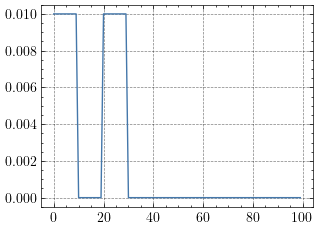

In [24]:
steps_per_step  = 10
steps_between   = 10
start           = 0
U_step          = 0.01
N_voltages      = 100
U_i                                                                             = np.zeros(N_voltages)
U_i[start:steps_per_step]                                                       = U_step
U_i[start+steps_per_step+steps_between:start+2*steps_per_step+steps_between]    = U_step

plt.plot(U_i)

Text(0.5, 0, '$t$ [ns]')

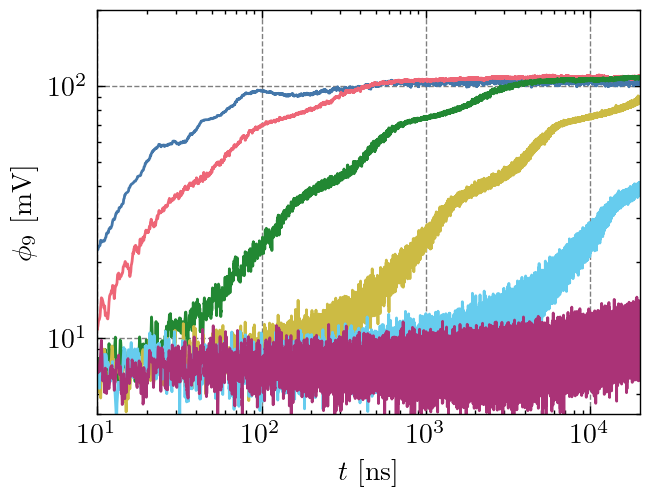

In [162]:
fig = plt.figure(dpi=200)
ax2 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    p   = pot_cap[key]['9']*1000
    ax2.plot(t_vals, p)

ax2.set_yscale('log')
ax2.set_ylim(5e0,2e2)
ax2.set_xscale('log')
ax2.set_xlim(10,np.max(t_vals))
ax2.set_ylabel('$\phi_9$ [mV]')
ax2.set_xlabel('$t$ [ns]')

In [109]:
t_at_68 = []

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > 0.068)[0][0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

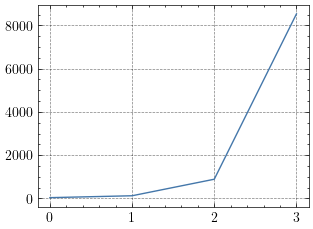

In [111]:
plt.plot(t_at_68)

In [151]:
def exp_saturation(x, tau, a0):
    return a0*(1 - np.exp(-x/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, alpha, beta, a0):
    return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)

/tmp/ipykernel_29226/3010679329.py:20: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

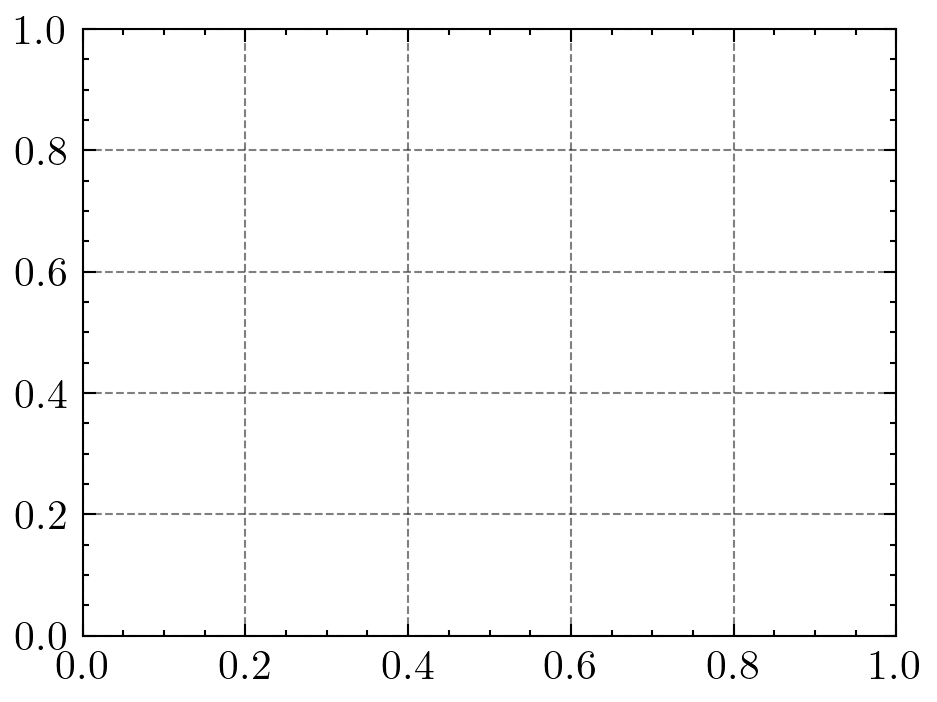

In [153]:
params  = []
stds    = []
func    = exp_power_law_saturation
p0      = [100, 1, 100]

fig = plt.figure(dpi=300)
ax  = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(func, t_vals, y, maxfev=2000, p0=[key, 10, 1, 1, 1])
    pl  = ax.plot(t_vals, y, '.', ms=1)
    ax.plot(t_vals, func(t_vals, *p), c=pl[0].get_color())

    params.append(p)
    stds.append(np.sqrt(c[0,0]))

    print(p)

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e3)
ax.set_xlim(0,50)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')